In [23]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import pandas as pd

In [17]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [19]:
engine = create_engine("sqlite:///hawaii.sqlite")


Base = automap_base()

In [7]:
# reflect an existing database into a new model

Base.prepare(engine, reflect=True)

# reflect the tables

Base.classes.keys()


/Users/davidlago/opt/anaconda3/envs/Pythondata/lib/python3.7/site-packages/sqlalchemy/ext/declarative/clsregistry.py:129: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.measurement, and will be replaced in the string-lookup table.
  % (item.__module__, item.__name__)
/Users/davidlago/opt/anaconda3/envs/Pythondata/lib/python3.7/site-packages/sqlalchemy/ext/declarative/clsregistry.py:129: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.station, and will be replaced in the string-lookup table.
  % (item.__module__, item.__name__)


['measurement', 'station']

In [8]:
# We can view all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station


In [10]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Climate Analysis

June
       precipitation
count    1574.000000
mean        0.136360
std         0.335731
min         0.000000
25%         0.000000
50%         0.020000
75%         0.120000
max         4.430000
-------------------
December
       precipitation
count    1405.000000
mean        0.216819
std         0.541399
min         0.000000
25%         0.000000
50%         0.030000
75%         0.150000
max         6.420000


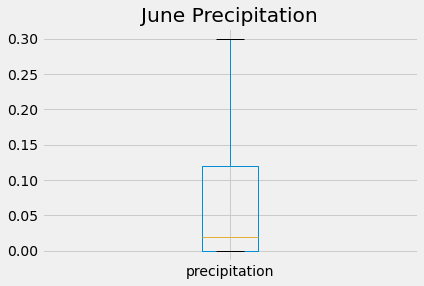

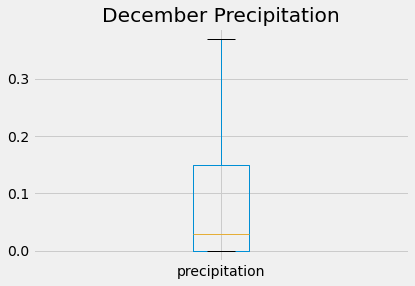

In [24]:
#setting the date range variables to encompass all data that we have
first_date = dt.date(2010, 1, 1)
last_date = dt.date(2017, 8, 23)

# Perform a query to retrieve the data and precipitation scores
results = []
results = session.query(Measurement.date, Measurement.prcp)
#print(results.all())
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','precipitation'])
df.set_index(df['date'], inplace=True)
#print(df.to_string(index=False))

# Sort the dataframe by date
df = df.sort_index()
#print(df['date'].dtype)

#converting dtype (object) of date dtype to dateime64
df['date'] = pd.to_datetime(df['date'])
#print(df['date'].dtype)

#create June dataframe and filter out nan
june_df = df[df['date'].dt.month==6]
junefil_df = june_df[~np.isnan(june_df['precipitation'])]

#create December dataframe and filter out nan
dec_df = df[df['date'].dt.month==12]
decfil_df = dec_df[~np.isnan(dec_df['precipitation'])]

#describe function for objective on statistics
print ('June')
print(junefil_df.describe())
print ('-------------------')
print ('December')
print(decfil_df.describe())

#plotting it out
junefil_df.boxplot(column='precipitation', showfliers=False).set_title('June Precipitation')
plt.show()
decfil_df.boxplot(column='precipitation', showfliers=False).set_title('December Precipitation')
plt.show()


       precipitation
count   18103.000000
mean        0.160644
std         0.468746
min         0.000000
25%         0.000000
50%         0.010000
75%         0.110000
max        11.530000


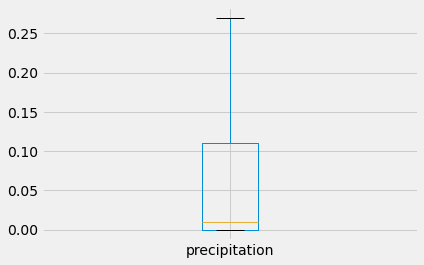

In [25]:
# Use Pandas to calcualte the summary statistics for ALL the precipitation data
print(df.describe())
df.boxplot(column='precipitation', showfliers=False)
plt.show()


In [26]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [27]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= prev_year).all()
#print(results)
df = pd.DataFrame(results, columns=['tobs'])

df.plot.hist(bins=12)
plt.tight_layout()

NameError: name 'prev_year' is not defined

In [38]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

start_date='2010-01-01'
end_date='2017-08-23'

def calc_temps(start_date,end_date):
    
    return (session.query(func.min(Measurement.tobs), 
                          func.round(
                          func.avg(Measurement.tobs)), 
                          func.max(Measurement.tobs))
                   .filter(Measurement.date >= start_date)
                   .filter(Measurement.date <= end_date)
                   .all())

trip_temp=calc_temps(start_date,end_date)
#print(trip_temp)

trip_temp_df=pd.DataFrame({'start_date': start_date,
                           'end_date': end_date,
                           'min_temp': [trip_temp[0][0]],
                           'avg_temp': [trip_temp[0][1]],
                           'max_temp': [trip_temp[0][2]]
                          })
trip_temp_df.set_index(['start_date','end_date'],inplace=True)
trip_temp_df

,,min_temp,avg_temp,max_temp
start_date,end_date,,,
2010-01-01,2017-08-23,53.0,73.0,87.0


# Challenge